In [2]:
import pandas as pd 
from matplotlib import pyplot as plt
import os
import cv2
import numpy as np
from matplotlib.pyplot import figure
import scipy.io
from  scipy.interpolate import interp1d

## UPDATED DRFS

In [3]:
face_codes = scipy.io.loadmat('face_codes.mat')
ufaces = face_codes['ufaces']

In [4]:
yalefaces = scipy.io.loadmat('yalefaces.mat')
yalefaces = yalefaces['yalefaces']

In [5]:
ufaces_df = pd.DataFrame(data=ufaces, columns=['face_id', 'first_img', 'last_img', 'race', 'gender'])

In [6]:
ufaces_df['face_id'] = ufaces_df['face_id'].apply(lambda x: x-1)
ufaces_df['first_img'] = ufaces_df['first_img'].apply(lambda x: x-1)
ufaces_df['last_img'] = ufaces_df['last_img'].apply(lambda x: x-1)

In [7]:
ufaces = np.array(ufaces_df)

In [8]:
ufaces[0:5]

array([[  0,   0,  63,   1,   5],
       [  1,  64, 127,   2,   5],
       [  2, 128, 191,   1,   5],
       [  3, 192, 255,   1,   5],
       [  4, 256, 319,   2,   6]])

In [9]:
NN = np.zeros((1,2414))
RR = np.zeros((1,2414))
GG = np.zeros((1,2414))

for i in range(0, ufaces.shape[0]):
    NN[0, ufaces[i,1]:ufaces[i,2]+1] = i
    RR[0, ufaces[i,1]:ufaces[i,2]+1] = ufaces[i,3]
    GG[0, ufaces[i,1]:ufaces[i,2]+1] = ufaces[i,4]

NN = NN.squeeze()
RR = RR.squeeze()
GG = GG.squeeze()

In [10]:
NN

array([ 0.,  0.,  0., ..., 37., 37., 37.])

In [11]:
human_sim_C_faces = scipy.io.loadmat('human_sim_C_faces.mat')

In [12]:
Present_Faces = human_sim_C_faces['Present_Faces']

In [13]:
Present_Faces

array([[ 3],
       [ 4],
       [ 6],
       [ 7],
       [10],
       [14],
       [15],
       [16],
       [17],
       [18]], dtype=uint8)

In [14]:
initial_target_person = Present_Faces[0,:] -1  #2
initial_excluded_face = Present_Faces[1,:] -1 #3

In [15]:
target_and_excluded = np.vstack((initial_target_person,initial_excluded_face)).T 
# target_and_excluded.size == (1, 2)

In [16]:
target_and_excluded

array([[2, 3]], dtype=uint8)

In [17]:
cutoffs = np.arange(100,2000,200) # size == (10,)

In [18]:
R2_RF_cmt = np.zeros((cutoffs.shape[0], 2)) # R2_RF_cmt.shape == (10, 2)

In [19]:
eigvvv = None
facee = None

In [20]:
def reconstruct_face(C_FACES, target_image, cutoff):
    global eigvvv
    global facee

    [h, w, n] = C_FACES.shape
    d = h * w
    x = np.reshape(C_FACES, (d, n), order="F")
    x = x.astype(float)
    mean_matrix = x.mean(axis=1)

    tiled_mean = np.tile(mean_matrix, (x.shape[1], 1))
    tiled_mean = tiled_mean.T
    Xtrain = x - tiled_mean
    s = np.cov(Xtrain)
 
    eigval, eigvec = np.linalg.eigh(s)

    eigval[::-1].sort()
    eigsum = eigval.sum(axis=0)
    eigvec = np.fliplr(eigvec)

    csum = 0
    for i in range(0,d):
        csum = csum + eigval[i]
        tv = csum / eigsum
        if tv > 0.95:
            k95 = i
            break

    
    FACE = yalefaces[:,:,target_image]
    FACE_reshaped = np.reshape(FACE, (2016, 1), order="F")
    FACE_reshaped = FACE_reshaped.astype(float).transpose()
    FACE_PROJECTED = np.dot(FACE_reshaped, eigvec)
    FACE_PROJECTED[0][cutoff:] = 0
    eigvvv = eigvec
    facee = FACE_PROJECTED
    FACE_RECONSTRUCTED = np.dot(FACE_PROJECTED, eigvec.transpose())
    

    return FACE_RECONSTRUCTED, eigvec, eigval, k95



In [21]:
# facee[0][100:] = 0

In [22]:
# facee[0][:100]

In [23]:
# (facee @ eigvvv.T).shape

In [25]:
# plt.imshow(np.reshape((facee @ eigvvv.T), (48, 42), order="F"))

In [ ]:
    # FACE = yalefaces[:,:,target_image]
    # FACE_reshaped = np.reshape(FACE, (1, 2016), order="F")
    # FACE_PROJECTED = np.matmul(FACE_reshaped, eigvec)
    # FACE_PROJECTED[cutoff-1:] = 0

    # FACE_RECONSTRUCTED = np.dot(FACE_PROJECTED, eigvec.transpose())

    # return FACE_RECONSTRUCTED, eigvec, eigval, k95

In [26]:
RF_cmt = np.empty(shape=(10,2016))
RF_cmt.fill(0)

RF_cm1 = np.empty(shape=(10,2016))
RF_cm1.fill(0)

In [27]:
initial_target_dRFs = np.empty(shape=(10,2))
initial_target_dRFs.fill(0)

initial_excluded_dRFs = np.empty(shape=(10,2))
initial_excluded_dRFs.fill(0)

In [28]:
ufaces[:5]

array([[  0,   0,  63,   1,   5],
       [  1,  64, 127,   2,   5],
       [  2, 128, 191,   1,   5],
       [  3, 192, 255,   1,   5],
       [  4, 256, 319,   2,   6]])

In [29]:
for t in range(0,len(target_and_excluded)+1):
    target_image = ufaces[target_and_excluded[:,t],1] #128 [Matlab 129]; 192 [Matlab 193]
    C_minus_1_ind = np.where(np.logical_and(RR == 1, NN != initial_excluded_face)) #shape (1659,) array([   0,    1,    2, ..., 2411, 2412, 2413])
    C_minus_T_ind = np.where(np.logical_and(RR == 1, NN != initial_target_person))

    LIB_C_minus_T = yalefaces[:,:,C_minus_T_ind].squeeze()
    LIB_C_minus_1 = yalefaces[:,:,C_minus_1_ind].squeeze()
    [h, w, n] = LIB_C_minus_T.shape
    cutoffs1 = np.arange(100,2001,50)

    for f in range(0,len(cutoffs)): # f = 0-9
        [RF_cmt[f,:], V_cmt, eigval_cmt, k95_cmt] = reconstruct_face(LIB_C_minus_T, target_image, cutoffs[f])
        # V_cmt.shape == (2016, 2016)
        # eigval_cmt.shape == (2016,)
        [RF_cm1[f,:], V_cm1, eigval_cm1, k95_cm1] = reconstruct_face(LIB_C_minus_1, target_image, cutoffs[f])
    target_image1 = yalefaces[:,:,target_image]
    re_target_image = np.reshape(target_image1, (1,2016), order="F" )
    print(RF_cmt[:, 0])
    for e in range(0,len(cutoffs)):
        initial_target_dRFs[e,t] = abs(re_target_image - RF_cmt[e,:]).sum(axis=1)
        initial_excluded_dRFs[e,t] = abs(re_target_image - RF_cm1[e,:]).sum(axis=1)

[76.49332396 83.15764556 80.19543004 87.75259834 87.0298223  86.78139044
 88.42926113 88.77316605 88.57448172 88.5744817 ]
[62.93830674 65.69101282 63.51834176 64.10649716 64.61238683 64.93379569
 64.86872313 64.99709946 65.01687487 65.01687486]


In [30]:
# columns: 0: target 1: exluded face
# rows: drf values for a face reconstructed with each cutoff - in subset minus target

initial_target_dRFs

array([[18485.59415132,  7748.09662205],
       [11104.92285878,  3749.85233898],
       [ 8061.73208722,  2081.87217073],
       [ 6425.48602735,  1394.02629083],
       [ 4921.39802801,   929.23131605],
       [ 3984.29421123,   681.13400634],
       [ 3235.6660716 ,   423.81682736],
       [ 2630.55744019,   155.85630523],
       [ 1969.88073142,    56.49105128],
       [ 1131.35723202,    32.64596688]])

In [31]:
# columns: 0: target 1: exluded face
# rows: drf values for a face reconstructed with each cutoff - in subset minus one face, target included

initial_excluded_dRFs

array([[10094.95051944, 11897.22488679],
       [ 4944.6816939 ,  7659.5141589 ],
       [ 2620.99158343,  5373.53077183],
       [ 1658.67325907,  4207.69183004],
       [ 1004.85491598,  3422.77398077],
       [  643.35288489,  2801.36920244],
       [  301.69847895,  2350.91393345],
       [  120.1563909 ,  1877.26967865],
       [   53.23328782,  1471.83168303],
       [   29.49117272,   846.62872267]])

## DRF SG 2

In [32]:
from numpy import sqrt
from scipy.linalg import sqrtm
from scipy.interpolate import interp1d
from numpy import interp

In [33]:
DRF_SUMMARY_2 = scipy.io.loadmat('DRF_SUMMARY_2.mat')

In [34]:
initial_target_dRFs = DRF_SUMMARY_2['initial_target_dRFs']

In [35]:
initial_excluded_dRFs = DRF_SUMMARY_2['initial_excluded_dRFs']

In [36]:
targets = np.concatenate((initial_target_person, initial_excluded_face), axis=0)

In [37]:
swap_targets = np.concatenate((initial_excluded_face, initial_target_person), axis=0)

In [38]:
targets

array([2, 3], dtype=uint8)

In [39]:
cnt=0

In [40]:
initial_target_dRFs

array([[18506.31553326,  8034.87243843],
       [11111.40223812,  3752.44438789],
       [ 8067.72792531,  2082.42282987],
       [ 6437.11457127,  1397.45517388],
       [ 4927.15560026,   933.81214818],
       [ 3985.70780176,   682.3540292 ],
       [ 3241.82266952,   424.73344226],
       [ 2640.73566391,   157.83893041],
       [ 1947.34025367,    56.65207459],
       [ 1152.58056404,    38.29260853]])

In [41]:
def find_matching_cutoff(CMT_inter, five_dRFs, cutoffs_fine):
    temp_pairs_CMT = abs(CMT_inter-five_dRFs)
    store_CMT_ind_pairs = np.argmin(temp_pairs_CMT)
    return cutoffs_fine[store_CMT_ind_pairs]


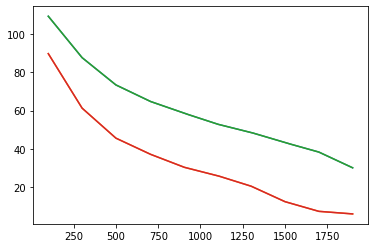

In [61]:
for f in range(0,len(targets)):
    cutoffs_fine = np.arange(cutoffs[0],cutoffs[-1]+1,5) 
    COs_fine = cutoffs_fine.shape
    d27 = initial_excluded_dRFs
    d14 = initial_target_dRFs

    d27 = sqrt(d27)
    d14 = sqrt(d14)
    CMT = np.array([d14[:,0], d27[:,1]])
    CM1 = np.array([d27[:,0], d14[:,1]])
    target = targets[t]
    swap_target = swap_targets[t]

    num = d27.shape[0]
    First_label = f'F{target} (+{target} -{swap_target})'
    Second_label = f'F{target} (+{target} -{swap_target})'
    
    CMT_inter = interp1d(cutoffs,d14[:,t])(cutoffs_fine)
    CM1_inter = interp1d(cutoffs,d27[:,t])(cutoffs_fine)
    
    CM1_inter_1 = interp1d(cutoffs,d27[:,0])(cutoffs_fine)
    CM1_inter_2 = interp1d(cutoffs,d14[:,1])(cutoffs_fine)

    CMT_inter_1 = interp1d(cutoffs,d14[:,0])(cutoffs_fine)
    CMT_inter_2 = interp1d(cutoffs,d27[:,1])(cutoffs_fine)

    CMT_inter = np.stack((CMT_inter_1,CMT_inter_2)) #2x361
    CM1_inter = np.stack((CM1_inter_1, CM1_inter_2))

    ref_CM1_drfs = np.stack((d27[:,0], d14[:,1]))
    
    five_CMT_cutoffs = np.zeros((1,5))
    five_CM1_cutoffs = np.zeros((1,5))
    store_CMT_ind = np.zeros((10))
    store_CM1_cutoffs = np.zeros((10,1))


    for i in range(num):
        temp1 = abs(CMT_inter[t,:] - CM1[t,i])
        store_CMT_ind[i] = np.argmin(temp1)
        store_CM1_cutoffs[i,:] = cutoffs[i]

    CM1_cutoffs = store_CM1_cutoffs

    CMT_cutoffs = cutoffs_fine[store_CMT_ind.astype(int)]
    CMT_cutoffs = np.reshape(CMT_cutoffs,(num,1), order='F')

    num_dRFs_pairs = 5
    first_dRF      = CM1_inter[t,0]
    last_dRF       = CMT_inter[t:]
    five_dRFs      = np.linspace(first_dRF,last_dRF,num_dRFs_pairs)


    EQd_CMT_COs = np.zeros((5))
    EQd_CM1_COs = np.zeros((5))

    for d in range(num_dRFs_pairs):
        EQd_CMT_COs[d] = find_matching_cutoff(CMT_inter[t,:],five_dRFs[d],cutoffs_fine)
        EQd_CM1_COs[d] = find_matching_cutoff(CM1_inter[t,:],five_dRFs[d],cutoffs_fine)

    plt.plot(cutoffs_fine,CMT_inter[t,:])
    plt.plot(cutoffs_fine,CM1_inter[t,:])




In [59]:
five_dRFs.squeeze()

array([[ 89.63744998,  89.63744998,  89.63744998, ...,  89.63744998,
         89.63744998,  89.63744998],
       [ 94.50656531,  94.37179616,  94.23702701, ...,  74.88047152,
         74.82925654,  74.77804155],
       [ 99.37568064,  99.10614234,  98.83660404, ...,  60.12349306,
         60.0210631 ,  59.91863313],
       [104.24479597, 103.84048852, 103.43618107, ...,  45.36651461,
         45.21286966,  45.0592247 ],
       [109.11391131, 108.57483471, 108.03575811, ...,  30.60953615,
         30.40467621,  30.19981628]])

In [43]:
EQd_CMT_COs

array([280., 280., 280., 280., 100.])

In [44]:
EQd_CM1_COs

array([100., 100., 100., 100., 100.])

In [51]:
five_dRFs[:, 0, 0]

array([ 89.63744998,  94.50656531,  99.37568064, 104.24479597,
       109.11391131])